In [1]:
# pip install gym tensorflow matplotlib numpy


In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Input
import matplotlib.pyplot as plt

cartpole_env = gym.make('CartPole-v1')


In [3]:
def build_neural_model_Q(state_space_size, action_space_size):
    model = tf.keras.Sequential([
        Input(shape=(state_space_size,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(action_space_size, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002))
    return model


In [4]:
discount_factor = 0.99
explore_epsilon = 1.0
epsilon_decay = 0.995
maximum_epsilon = 0.75
learning_value = 0.09
num_episodes = 100
num_repetitons = 5
target_steps = 2000 ##across all episodes in a run


In [5]:
state_size_sample = cartpole_env.observation_space.shape[0]
action_size_sample = cartpole_env.action_space.n
model_sample = build_neural_model_Q(state_size_sample, action_size_sample)
target_model_sample = build_neural_model_Q(state_size_sample, action_size_sample)

In [6]:
def update_target_network():
    target_model_sample.set_weights(model_sample.get_weights())
    print("Updated target network weights.")# Function to choose an action using epsilon-greedy strategy
# if the explore_epsilon is lesser than the random number generated, generate a random action




In [7]:
def epsilon_greedy_action(state):
    if isinstance(state, tuple):  
        state = state[0]  
    state_reshaped = np.array(state).reshape(1, -1)  
    
    if np.random.uniform(0, 1) > explore_epsilon:
        return cartpole_env.action_space.sample()
    else: #choose best action according to knowledge
        state_reshaped = state.reshape(1, -1)  # shape: (1, 4) # implicit batch definition of size 1
        model_q_values = model_sample.predict(state_reshaped, verbose=0)
        return np.argmax(model_q_values[0])  # according to the model the system would benefit from taking right action here. only different to left action by a slight amount

# state = cartpole_env.reset()
# print(f"State: {state}") # here there is a 1*4 output for state
# action = epsilon_greedy_action(state)
# print(f"Chosen action: {action}")


In [8]:
from tensorflow.keras.optimizers import Adam
model_sample.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error')


In [9]:
#used to update the Q-values in the training stage
def bellman_update_training(current_state, action, immediate_reward, next_state, terminated, steps_taken=None, max_steps=None):

    if isinstance(current_state, tuple): 
        current_state = current_state[0] 
        
    cumulative_reward = immediate_reward # reward taken for taking action in current_state
    priority = 1 #default priority for normal episode

    #-----prioritycase2-----, give priority to bad experiences where going to the target takes alot of steps
    # ----prioritycase3-----, give priority to bad experiences where we never reach the target but steps complete
    #-----prioritycase4----, give priority to bad experiences where we reach sub-optimal solution but program thinks its target

    #prioritycase2
    if steps_taken is not None and max_steps is not None:
        if steps_taken > 0.5 * max_steps:
            priority = 2  # defining edge case

    #prioritycase3
    if terminated and steps_taken < max_steps * 0.7:
        priority = 3

    #prioritycase4
    if not terminated and immediate_reward<1:
        priority = 4

    print(f"Designated Priority: {priority}")

    # updating target if epsiode is not terminated
    if not terminated:
        next_state_reshaped = next_state.reshape(1, -1)
        next_q_values = target_model_sample.predict(next_state_reshaped,verbose=0)
        cumulative_reward = immediate_reward + discount_factor * np.max(next_q_values[0]) # target is updated to be this

    state_reshaped = current_state.reshape(1, -1)
    q_values = model_sample.predict(state_reshaped, verbose=0) # expected future rewards from current state
    print(f"Q-values before update: {q_values}")

    if priority == 1:
       learning_value = 0.1

    elif priority == 2:
        learning_value = 0.2

    elif priority == 3:
        learning_value = 0.5

    elif priority == 4:
        learning_value = 0.8

    q_values[0][action] = (1 - learning_value) * q_values[0][action] + learning_value * cumulative_reward

    model_sample.fit(state_reshaped, q_values, verbose=0) #train model on updated q value

    q_values_updated = model_sample.predict(state_reshaped, verbose=0)
    print(f"Q-values after update: {q_values_updated}")


current_state = np.array([0.2, 0.1, 0.0, 0.0])
next_state = np.array([0.3, 0.1, 0.0, 0.0])
steps_taken = 10
max_steps = 15
immediate_reward = 1
terminated = False
priority = bellman_update_training(current_state, 1, immediate_reward, next_state, terminated, steps_taken=steps_taken, max_steps=max_steps)
print('-' * 100)

#we can test with different parameters to this function to see how priority changes



Designated Priority: 2


Q-values before update: [[-0.05080283 -0.00311504]]
Q-values after update: [[-0.05194476  0.02467428]]
----------------------------------------------------------------------------------------------------


In [10]:
#this function is used to train the neural network overall.
# used to show program how to update the states, take actions and reset.
# tracking the performance so it can be plotted using graphs

def overall_training_neural_network():
    global explore_epsilon
    rewards_per_episode = []
    for episode in range(num_episodes):
        state = cartpole_env.reset()  # Reset environment to get initial state for each episode beginning
        cumulative_reward = 0 # keeps track of cumulative reward accumulated in an episode
        steps_taken = 0 # keeps track of number of steps taken in an episode
        terminated = False #indicates program whether an episode or run has ended
        truncated = False

        while not terminated:
            action = epsilon_greedy_action(state)  # Select action using epsilon-greedy function we defined
            next_state, immediate_reward, terminated, cut_short, ignored_meta_data = cartpole_env.step(action)  # Take action in the environment
            bellman_update_training(state, action, immediate_reward, next_state, terminated, steps_taken=steps_taken, max_steps=200)  # Update Q-values using bellman function defined
            state = next_state
            cumulative_reward += immediate_reward
            steps_taken += 1

        # Decay epsilon (exploration rate) after each episode
        explore_epsilon = max(maximum_epsilon, explore_epsilon * epsilon_decay)

        rewards_per_episode.append(cumulative_reward)
        print(f"Episode {episode + 1} out of total {num_episodes}, "f"Total Reward: {cumulative_reward}, Epsilon: {explore_epsilon:.2f}, "
        f"Current State: {state}, Steps Taken: {steps_taken}")


    return rewards_per_episode

# k = overall_training_neural_network()
# print(k)



In [ ]:
rewards_all_runs = []

for repetition in range(num_repetitons):
    rewards_per_episode = overall_training_neural_network()
    rewards_all_runs.append(rewards_per_episode)

rewards_all_runs = np.array(rewards_all_runs)



c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Designated Priority: 1
Q-values before update: [[-0.00913528  0.01520598]]
Q-values after update: [[-0.00869498  0.03218609]]
Designated Priority: 1
Q-values before update: [[-0.0336323   0.01229951]]
Q-values after update: [[-0.03991462  0.03405022]]
Designated Priority: 1
Q-values before update: [[-0.07082301  0.04646318]]
Q-values after update: [[-0.08518673  0.07800846]]
Designated Priority: 1
Q-values before update: [[-0.12065895  0.10140304]]
Q-values after update: [[-0.1497648   0.14426066]]
Designated Priority: 1
Q-values before update: [[-0.19252299  0.17943984]]
Q-values after update: [[-0.2363845   0.23328203]]
Designated Priority: 1
Q-values before update: [[-0.28926942  0.2806724 ]]
Q-values after update: [[-0.34681323  0.3484438 ]]
Designated Priority: 1
Q-values before update: [[-0.41145995  0.4089237 ]]
Q-values after update: [[-0.48099664  0.4961165 ]]
Designated Priority: 3
Q-values before update: [[-0.55833316  0.57185787]]
Q-values after update: [[-0.61329657  0.645

NameError: name 'num_repetitions' is not defined

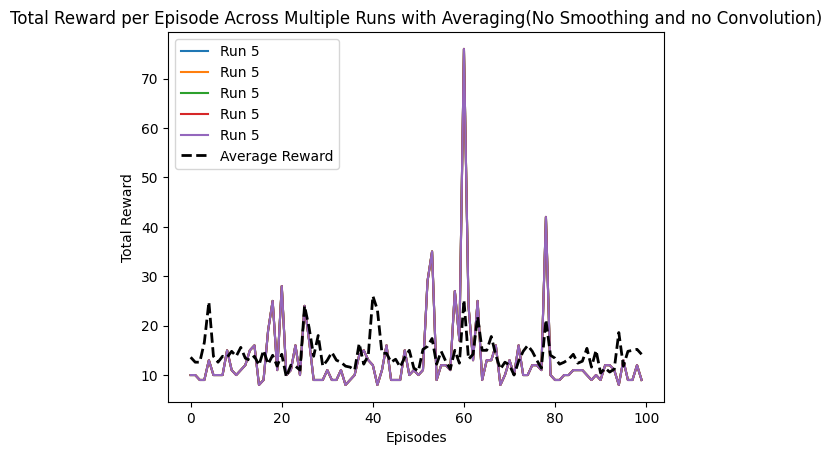

In [12]:
for repetiton in range(num_repetitons):
    plt.plot(rewards_all_runs[repetition], label=f'Run {repetition + 1}')

avg_rewards = np.mean(rewards_all_runs, axis=0)
plt.plot(avg_rewards, label='Average Reward', color='black', linestyle='--', linewidth=2)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode Across Multiple Runs with Averaging(No Smoothing and no Convolution)')
plt.legend(loc='upper left')
plt.show()